### Load libraries and functions

In [1]:

import matplotlib.pyplot as plt
from cobra.flux_analysis import pfba
from cobra.flux_analysis.loopless import loopless_solution

import sys
sys.path.insert(0, '../src/')

from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model
from load_modify_sample_utils import sample_optgp

from loopless_utils import loops_enumeration_from_fva, get_loopless_solutions_from_samples, calculate_affected_samples, loopy_reactions_turned_off_in_pfba
from loopless_utils import calculate_distances_from_samples, calculate_distances_from_reactions, violin_plot_samples_distances


### Load and inspect model (for more info see `load_modify_samply.ipynb`)

In [2]:

ec_cobra_model, ec_cobra_reactions, ec_cobra_reaction_ids,  = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds)


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
{'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.

### Identify loopy reactions in model

The function `loops_enumeration_from_fva` calculates possible loopy reaction in model and returns a list. Each item in the list is a tuple of a string (reaction ID) and a float (loopy score returned from the function)

In [6]:

loopy_reactions_fva = loops_enumeration_from_fva(ec_cobra_model, fraction_of_optimum=0.999)
print(loopy_reactions_fva)

loopy_reactions = [item[0] for item in loopy_reactions_fva]
print(loopy_reactions)


[('SUCDi', 994.7794007141794), ('FRD7', 995.0539767141795)]
['SUCDi', 'FRD7']


### Perform `pFBA` and `loopless_solution` to identify which of the loopy reactions can be removed

This logic is implemented in the `loopy_reactions_turned_off_in_pfba` function to automatically turn off loopy reactions with a pFBA flux value approaching 0 (useful in large models)

In [4]:

ec_cobra_model_copy = ec_cobra_model.copy()
solution_pFBA = pfba(ec_cobra_model_copy)
print(solution_pFBA.fluxes.FRD7)
print(solution_pFBA.fluxes.SUCDi)

pfba_loopless_solution = loopless_solution(ec_cobra_model_copy, solution_pFBA)
print(pfba_loopless_solution.fluxes.FRD7)
print(pfba_loopless_solution.fluxes.SUCDi)


Read LP format model from file /tmp/tmpd9nzaoiz.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


0.0
5.0643756614821
0.0
5.064375661482091


In [8]:

turned_off_reactions = loopy_reactions_turned_off_in_pfba(ec_cobra_model, loopy_reactions, tol = 1e-6)
print(turned_off_reactions)


Read LP format model from file /tmp/tmpqcbil9r8.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['FRD7']


### Modify model. Create a duplicate with "FRD7" (loopy reaction) removed (for more info see `load_modify_samply.ipynb`)

With this we can reduce the thermodynamically infeasible solutions from flux sampling

In [9]:

ec_cobra_default_model = modify_model(
                                    ec_cobra_model,
                                    objective_function="BIOMASS_Ecoli_core_w_GAM",
                                    optimal_percentage=100)

ec_cobra_model_frd7_removed = ec_cobra_model.copy()
ec_cobra_model_frd7_removed.reactions.get_by_id("FRD7").bounds = (0, 0)


Read LP format model from file /tmp/tmp0apnhjel.lp
Reading time = 0.00 seconds


: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpm230b_ws.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros


### Perform sampling on the default model and on a modified model with the loopy reaction "FRD7" removed. (for more info see `load_modify_samply.ipynb`)

In [ ]:

samples_optgp_default = sample_optgp(ec_cobra_default_model, 
                                           n_samples = 3000, 
                                           thinning=100, 
                                           reaction_in_rows = True)

print(samples_optgp_default.shape)


samples_optgp_frd7_removed = sample_optgp(ec_cobra_model_frd7_removed, 
                                         n_samples = 3000, 
                                         thinning=100, 
                                         reaction_in_rows = True)

print(samples_optgp_frd7_removed.shape)


samples_default = samples_optgp_default
samples_frd7_removed = samples_optgp_frd7_removed


Read LP format model from file /tmp/tmpw3qw15_v.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


(95, 3000)
Read LP format model from file /tmp/tmp6thmr0og.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
(95, 3000)


### Calculate the `loopless_solution` of the samples

The `get_loopless_solutions_from_samples` function calculates the `loopless_solution` from each sample and saves results into a new numpy 2D array

In [13]:

samples_default_loopless_solutions = get_loopless_solutions_from_samples(samples_default, ec_cobra_model)

print(samples_default.shape)
print(samples_default_loopless_solutions.shape)


samples_frd7_removed_loopless_solutions = get_loopless_solutions_from_samples(samples_frd7_removed, ec_cobra_model)

print(samples_frd7_removed.shape)
print(samples_frd7_removed_loopless_solutions.shape)


/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


(95, 3000)
(95, 3000)
(95, 3000)
(95, 3000)


### Check if FRD7 and SUCDi are loopy across most of the samples

With this we can check whether the calculated loopy reactions affect few (histogram peak near 0) or most (histogram peak not near 0 or uniform distances) samples

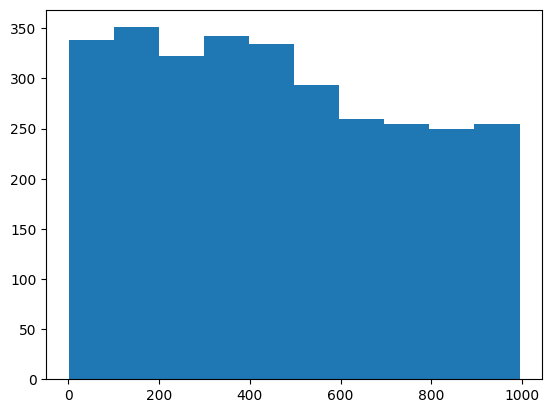

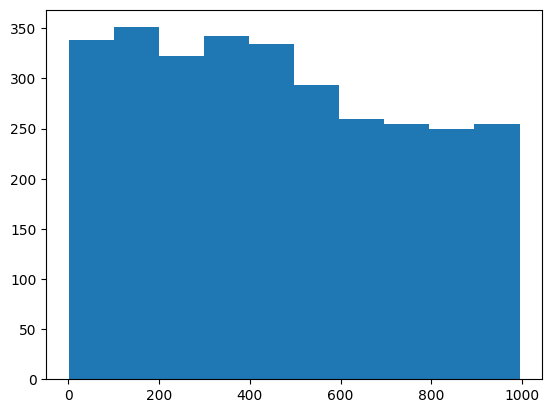

In [14]:

change_per_reaction = abs(samples_default) - abs(samples_default_loopless_solutions)
   
reaction_index = ec_cobra_reaction_ids.index("FRD7")
change_FRD7 = change_per_reaction[reaction_index]

plt.hist(change_FRD7)
plt.show()


reaction_index = ec_cobra_reaction_ids.index("SUCDi")
change_FRD7 = change_per_reaction[reaction_index]

plt.hist(change_FRD7)
plt.show()


### Find how many samples (e.g. percentage) from the initial sampling have significant differences with themselves after applying loopless solution.

The `calculate_affected_samples` function identifies how many samples have significant differences (before and after applying the `get_loopless_solutions_from_samples`). This is done by calculating (for each sample) the distance (change) of the reactions from the given arrays. Reactions that have a difference higher than a given threshold are counted and the corresponding sample can potentially be classified as a loopy sample.

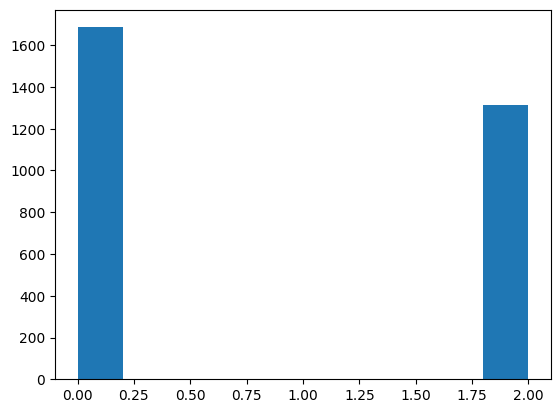

1314 affected samples out of (95, 3000) total samples


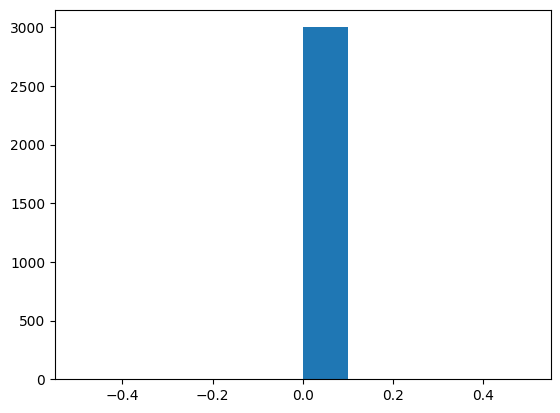

0 affected samples out of (95, 3000) total samples


In [15]:

affected_reactions_count, total_affected_samples = calculate_affected_samples(samples_default, 
                                                                              samples_default_loopless_solutions, 
                                                                              ec_cobra_model, 
                                                                              tol_reaction_difference=0.5, 
                                                                              tol_reactions_count=1)

plt.hist(affected_reactions_count)
plt.show()
    
print(total_affected_samples, "affected samples out of", (samples_default).shape, "total samples")



affected_reactions_count, total_affected_samples = calculate_affected_samples(samples_frd7_removed, 
                                                                              samples_frd7_removed_loopless_solutions, 
                                                                              ec_cobra_model, 
                                                                              tol_reaction_difference=0.5, 
                                                                              tol_reactions_count=1)

plt.hist(affected_reactions_count)
plt.show()
    
print(total_affected_samples, "affected samples out of", (samples_frd7_removed).shape, "total samples")


### Calculate distances between samples before and after the `get_loopless_solutions_from_samples` and plot the distances array

The `calculate_distances_from_reactions` function calculates the euclidean distance between a sampling dataset before and after applying the `get_loopless_solutions_from_samples`. Distances are calculated between different reactions, so if user provides samples of 100 reactions, he will end up with 100 distances.    

The `calculate_distances_from_samples` function calculates the euclidean distance between a sampling dataset before and after applying the `get_loopless_solutions_from_samples`. Distances are calculated between different samples, so if user has 3000 samples, he will end up with 3000 distances.

The `violin_plot_samples_distances` is used to create a violin plot to visualize the distances.

In [17]:

distances_array = calculate_distances_from_reactions(samples_default, samples_default_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)

distances_array = calculate_distances_from_samples(samples_default, samples_default_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)



distances_array = calculate_distances_from_reactions(samples_frd7_removed, samples_frd7_removed_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array, exponentformat="none")

distances_array = calculate_distances_from_samples(samples_frd7_removed, samples_frd7_removed_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array, exponentformat="none")
